
# **基于resnet的猫狗分类**
图像分类是根据图像的语义信息将不同类别图像区分开来，是计算机视觉中重要的基本问题

猫狗分类属于图像分类中的粗粒度分类问题

![](https://ai-studio-static-online.cdn.bcebos.com/1cd9ef37036647c2afbbc866a7d2c14179f33cf1e2494d1f8f00de556d231452)


## **首先导入必要的包**

paddle--->PaddlePaddle深度学习框架

os------------->python的模块，可使用该模块对操作系统进行操作

numpy---------->python第三方库，用于进行科学计算

PIL------------> Python Image Library,python第三方图像处理库

matplotlib----->python的绘图库 pyplot:matplotlib的绘图框架

os------------->提供了丰富的方法来处理文件和目录

sys------------->供对解释器使用或维护的一些变量的访问，以及与解释器强烈交互的函数。

pickle---------->模块实现了基本的数据序列和反序列化

In [1]:
# 导入需要的包
import paddle
import os 
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import sys
import pickle
from paddle.vision.transforms import ToTensor
import paddle.nn.functional as F
print("本教程基于Paddle的版本号为："+paddle.__version__)

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/layers/utils.py:26: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  def convert_to_list(value, n, name, dtype=np.int):
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/__init__.py:107: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import MutableMapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matp

本教程基于Paddle的版本号为：2.0.2


## **Step1:准备数据**
### 自定义数据集
**（1）数据集介绍**

我们使用CIFAR10数据集。CIFAR10数据集包含60,000张32x32的彩色图片，10个类别，每个类包含6,0000张。其中50,000张图片作为训练集，10000张作为验证集。这次我们只对其中的猫和狗两类进行预测。

![](https://ai-studio-static-online.cdn.bcebos.com/567016c028714d21bfe690dee70e9ea31512ba3575bd4d7caebbb7ade05c72ac)

**(2)train_dataset和eval_dataset**

自定义读取器处理训练集和测试集

paddle.reader.shuffle()表示每次缓存BUF_SIZE个数据项，并进行打乱

paddle.batch()表示每BATCH_SIZE组成一个batch

In [2]:
'''
参数配置
'''
train_parameters = {
    "input_size": [3, 32, 32],                           #输入图片的shape
    "src_path":"/home/aistudio/data/data9154/cifar-10-python.tar.gz",       #原始数据集路径
    "target_path":"/home/aistudio/cifar-10-batches-py",        #要解压的路径 
    "num_epochs": 1,                                    #训练轮数
    "train_batch_size": 64,                             #批次的大小
    "learning_strategy": {                              #优化函数相关的配置
        "lr": 0.001                                     #超参数学习率
    } 
}

In [3]:
def unzip_data(src_path,target_path):

    '''
    解压原始数据集，将src_path路径下的zip包解压至/home/aistudio/目录下
    '''

    if(not os.path.isdir(target_path)):    
        import tarfile
        tar = tarfile.open(src_path,'r')
        tar.extractall(PATH=target_path)
        tar.close()
    else:
        print("文件已解压")

In [4]:
'''
参数初始化
'''
src_path=train_parameters['src_path']
target_path=train_parameters['target_path']
batch_size=train_parameters['train_batch_size']
image_size=train_parameters['input_size']
epoch_num=train_parameters['num_epochs']
lr=train_parameters['learning_strategy']['lr']
'''
解压原始数据到指定路径
'''
unzip_data(src_path,target_path)

文件已解压


In [5]:
#定义数据序列化函数
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

print(unpickle("cifar-10-batches-py/data_batch_1").keys())
print(unpickle("cifar-10-batches-py/test_batch").keys())

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])
dict_keys([b'batch_label', b'labels', b'data', b'filenames'])


In [6]:
'''
自定义数据集
'''
from paddle.io import Dataset
class MyDataset(paddle.io.Dataset):
    """
    步骤一：继承paddle.io.Dataset类
    """
    def __init__(self, mode='train'):
        """
        步骤二：实现构造函数，定义数据集大小
        """
        super(MyDataset, self).__init__()
        if mode == 'train':
            xs=[]
            ys=[]
            self.data = []
            self.label = []
            #批量读入数据
            for i in range(1,6):
                train_dict=unpickle("cifar-10-batches-py/data_batch_%d" % (i,))
                xs.append(train_dict[b'data'])
                ys.append(train_dict[b'labels'])
            #拼接数据
            Xtr = np.concatenate(xs)
            Ytr = np.concatenate(ys)
            #数据归一化处理
            for (x,y) in zip(Xtr,Ytr):  
                x= x.flatten().astype('float32')/255.0
                x= x.reshape(image_size)
                #将数据同一添加到data和label中
                self.data.append(x)
                self.label.append(np.array(y).astype('int64'))
        else:
            self.data = []
            self.label = []
            #读入数据
            test_dict=unpickle("cifar-10-batches-py/test_batch")
            X=test_dict[b'data']
            Y=test_dict[b'labels']
            for (x,y) in zip(X,Y):  
                #数据归一化处理
                x= x.flatten().astype('float32')/255.0
                x= x.reshape(image_size)
                #将数据同一添加到data和label中
                self.data.append(x)
                self.label.append(np.array(y).astype('int64'))
    def __getitem__(self, index):
        """
        步骤三：实现__getitem__方法，定义指定index时如何获取数据，并返回单条数据（训练数据，对应的标签）
        """
        #返回单一数据和标签
        data = self.data[index]
        label = self.label[index]
        #注：返回标签数据时必须是int64
        return data, np.array(label, dtype='int64')
    def __len__(self):
        """
        步骤四：实现__len__方法，返回数据集总数目
        """
        #返回数据总数
        return len(self.data)

# 测试定义的数据集
train_dataset = MyDataset(mode='train')
eval_dataset = MyDataset(mode='val')
print('=============train_dataset =============')
#输出数据集的形状和标签
print(train_dataset.__getitem__(1)[0].shape,train_dataset.__getitem__(1)[1])
#输出数据集的长度
print(train_dataset.__len__())
print('=============eval_dataset =============')
#输出数据集的形状和标签
for data, label in eval_dataset:
    print(data.shape, label)
    break
#输出数据集的长度
print(eval_dataset.__len__())

=============train_dataset =============
(3, 32, 32) 9
50000
=============eval_dataset =============
(3, 32, 32) 3
10000


### 飞桨内置数据集

本案例将会介绍飞桨提供的API完成数据集的下载并为后续的训练任务准备好数据迭代器。cifar10数据集由60000张大小为32 * 32的彩色图片组成，其中有50000张图片组成了训练集，另外10000张图片组成了测试集。这些图片分为10个类别，将训练一个模型能够把图片进行正确的分类。

这种方式跟上方的自定义数据集是一样的，只不过飞桨帮助大家进行了封装，使用更加方便~

In [7]:
print('飞桨内置数据集：', paddle.vision.datasets.__all__)

飞桨内置数据集： ['DatasetFolder', 'ImageFolder', 'MNIST', 'FashionMNIST', 'Flowers', 'Cifar10', 'Cifar100', 'VOC2012']


In [8]:
# transform = ToTensor()
# train_dataset = paddle.vision.datasets.Cifar10(mode='train',
#                                                transform=transform)
# eval_dataset = paddle.vision.datasets.Cifar10(mode='test',
#                                               transform=transform)

In [9]:
Batch=0
Batchs=[]
all_train_accs = []
def draw_train_acc(Batchs, train_accs):
    title="training accs"
    plt.title(title, fontsize=24)
    plt.xlabel("batch", fontsize=14)
    plt.ylabel("acc", fontsize=14)
    plt.plot(Batchs, train_accs, color='green', label='training accs')
    plt.legend()
    plt.grid()
    plt.show()
all_train_loss = []
def draw_train_loss(Batchs, train_loss):
    title="training loss"
    plt.title(title, fontsize=24)
    plt.xlabel("batch", fontsize=14)
    plt.ylabel("loss", fontsize=14)
    plt.plot(Batchs, train_loss, color='red', label='training loss')
    plt.legend()
    plt.grid()
    plt.show()

## **Step2.网络配置**

**（1）RESNET网络模型**

![](https://ai-studio-static-online.cdn.bcebos.com/3ae4dc4ebb3947fab983aefef213a7f803976bb5947b45e88d8732b06e4b200d)

本示例直接调用飞桨API内置网络，resnet18进行训练！

**（2）飞桨内置网络**

In [10]:
print('飞桨内置网络：', paddle.vision.models.__all__)

飞桨内置网络： ['ResNet', 'resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152', 'VGG', 'vgg11', 'vgg13', 'vgg16', 'vgg19', 'MobileNetV1', 'mobilenet_v1', 'MobileNetV2', 'mobilenet_v2', 'LeNet']


In [11]:
model = paddle.vision.models.resnet50()
paddle.summary(model,(1,3,32,32))

-------------------------------------------------------------------------------
   Layer (type)         Input Shape          Output Shape         Param #    
     Conv2D-1         [[1, 3, 32, 32]]     [1, 64, 16, 16]         9,408     
   BatchNorm2D-1     [[1, 64, 16, 16]]     [1, 64, 16, 16]          256      
      ReLU-1         [[1, 64, 16, 16]]     [1, 64, 16, 16]           0       
    MaxPool2D-1      [[1, 64, 16, 16]]      [1, 64, 8, 8]            0       
     Conv2D-2         [[1, 64, 8, 8]]       [1, 64, 8, 8]         36,864     
   BatchNorm2D-2      [[1, 64, 8, 8]]       [1, 64, 8, 8]           256      
      ReLU-2          [[1, 64, 8, 8]]       [1, 64, 8, 8]            0       
     Conv2D-3         [[1, 64, 8, 8]]       [1, 64, 8, 8]         36,864     
   BatchNorm2D-3      [[1, 64, 8, 8]]       [1, 64, 8, 8]           256      
   BasicBlock-1       [[1, 64, 8, 8]]       [1, 64, 8, 8]            0       
     Conv2D-4         [[1, 64, 8, 8]]       [1, 64, 8, 8]     

{'total_params': 11699112, 'trainable_params': 11679912}

## **Step3.模型训练**

### 方式1：基于基础API，完成模型的训练与预测

接下来，用一个循环来进行模型的训练，将会:

使用 paddle.optimizer.Adam 优化器来进行优化。

使用 F.cross_entropy 来计算损失值。

使用 paddle.io.DataLoader 来加载数据并组建batch。

start training ... 


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/nn/layer/norm.py:648: UserWarning: When training, we now always track global mean and variance.
  "When training, we now always track global mean and variance.")


train_pass:0,batch_id:100,train_loss:[1.630249],train_acc:[0.359375]
train_pass:0,batch_id:200,train_loss:[1.3312485],train_acc:[0.546875]
train_pass:0,batch_id:300,train_loss:[1.509393],train_acc:[0.53125]
train_pass:0,batch_id:400,train_loss:[1.19764],train_acc:[0.578125]
train_pass:0,batch_id:500,train_loss:[1.405709],train_acc:[0.53125]
train_pass:0,batch_id:600,train_loss:[0.9647112],train_acc:[0.6875]
train_pass:0,batch_id:700,train_loss:[1.1553544],train_acc:[0.59375]


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data


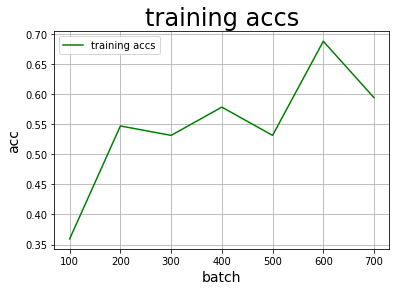

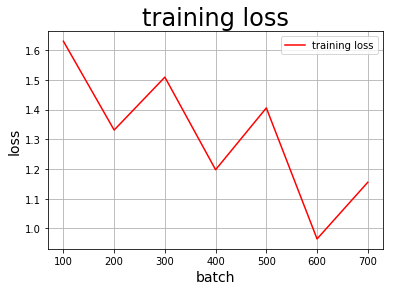

In [12]:
print('start training ... ')
# turn into training mode
model.train()

opt = paddle.optimizer.Adam(learning_rate=lr,
                            parameters=model.parameters())

train_loader = paddle.io.DataLoader(train_dataset,
                                    shuffle=True,
                                    batch_size=batch_size)

valid_loader = paddle.io.DataLoader(eval_dataset, batch_size=batch_size)

for epoch in range(epoch_num):
    for batch_id, data in enumerate(train_loader()):
        x_data = data[0]
        y_data = paddle.to_tensor(data[1])
        y_data = paddle.unsqueeze(y_data, 1)

        logits = model(x_data)
        loss = F.cross_entropy(logits, y_data)
        acc = paddle.metric.accuracy(logits,y_data)#计算精度
        if batch_id!=0 and batch_id%100==0:
            Batch = Batch + 100 
            Batchs.append(Batch)
            all_train_loss.append(loss.numpy()[0])
            all_train_accs.append(acc.numpy()[0])
            print("train_pass:{},batch_id:{},train_loss:{},train_acc:{}".format(epoch,batch_id,loss.numpy(),acc.numpy()))
        loss.backward()
        opt.step()
        opt.clear_grad() #opt.clear_grad()来重置梯度
paddle.save(model.state_dict(),'resnet18')#保存模型
draw_train_acc(Batchs,all_train_accs)
draw_train_loss(Batchs,all_train_loss)

### 模型验证
训练完成后，需要验证模型的效果，此时，加载测试数据集，然后用训练好的模对测试集进行预测，计算损失与精度。

In [13]:
#模型评估
para_state_dict = paddle.load("resnet18")
model.set_state_dict(para_state_dict) #加载模型参数
model.eval() #训练模式

accs = []

for batch_id,data in enumerate(valid_loader()):#测试集
    x_data = data[0]
    y_data = paddle.to_tensor(data[1])
    y_data = paddle.unsqueeze(y_data, 1)
    logits = model(x_data)
    acc = paddle.metric.accuracy(logits, y_data)
    accs.append(acc.numpy())
    avg_acc = np.mean(accs)
    
print("当前模型在验证集上的准确率为:",avg_acc)

当前模型在验证集上的准确率为: 0.56399286


### 模型预测

In [14]:
# 图片预处理
def load_image(file):
        '''
        预测图片预处理
        '''
        #打开图片
        im = Image.open(file)
        #将图片调整为跟训练数据一样的大小  32*32，设定ANTIALIAS，即抗锯齿.resize是缩放
        im = im.resize((32, 32), Image.ANTIALIAS)
        #建立图片矩阵 类型为float32
        im = np.array(im).astype(np.float32)
        #矩阵转置 
        im = im.transpose((2, 0, 1))                               
        #将像素值从【0-255】转换为【0-1】
        im = im / 255.0
        #print(im)       
        im = np.expand_dims(im, axis=0)
        # 保持和之前输入image维度一致
        print('im_shape的维度：',im.shape)
        return im

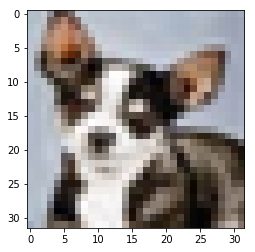

im_shape的维度： (1, 3, 32, 32)
dog


In [15]:
'''
模型预测
'''
para_state_dict = paddle.load("resnet18")
model = paddle.vision.models.resnet18()
model.set_state_dict(para_state_dict) #加载模型参数
model.eval() #训练模式

#展示预测图片
infer_path='/home/aistudio/data/data7940/dog.png'
img = Image.open(infer_path)
plt.imshow(img)          #根据数组绘制图像
plt.show()               #显示图像

#对预测图片进行预处理
infer_img = load_image(infer_path)
infer_img = infer_img.reshape(3,32,32)

#定义标签列表
label_list = [ "airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse","ship", "truck"]

data = infer_img
dy_x_data = np.array(data).astype('float32')
dy_x_data=dy_x_data[np.newaxis,:, : ,:]
img = paddle.to_tensor (dy_x_data)
out = model(img)
lab = np.argmax(out.numpy())  #argmax():返回最大数的索引
print(label_list[lab])

### 方式2：基于高层API，完成模型的训练与预测

In [16]:
#step3:训练模型
# 用Model封装模型
model = paddle.Model(model)
# 定义损失函数
model.prepare(optimizer=paddle.optimizer.Adam(parameters=model.parameters()),
                    loss=paddle.nn.CrossEntropyLoss(),
                    metrics=paddle.metric.Accuracy())
# 训练可视化VisualDL工具的回调函数
visualdl = paddle.callbacks.VisualDL(log_dir='visualdl_log')
# 启动模型全流程训练
model.fit(train_dataset,            # 训练数据集
           eval_dataset,            # 评估数据集
          epochs=epoch_num,            # 总的训练轮次
          batch_size = batch_size,    # 批次计算的样本量大小
          shuffle=True,             # 是否打乱样本集
          verbose=1,                # 日志展示格式
          save_dir='./chk_points/', # 分阶段的训练模型存储路径
          callbacks=[visualdl])     # 回调函数使用
#保存模型
model.save('model_save_dir')

The loss value printed in the log is the current step, and the metric is the average value of previous step.
Epoch 1/1
step  10/782 [..............................] - loss: 1.0995 - acc: 0.6062 - ETA: 25s - 33ms/step

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/layers/utils.py:77: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return (isinstance(seq, collections.Sequence) and


step 782/782 [==============================] - loss: 1.0933 - acc: 0.6358 - 21ms/step        
save checkpoint at /home/aistudio/chk_points/0
Eval begin...
The loss value printed in the log is the current batch, and the metric is the average value of previous step.
step 157/157 [==============================] - loss: 0.8053 - acc: 0.6242 - 10ms/step        
Eval samples: 10000
save checkpoint at /home/aistudio/chk_points/final


### 模型验证

In [17]:
model.evaluate(eval_dataset, batch_size=batch_size, verbose=1)

Eval begin...
The loss value printed in the log is the current batch, and the metric is the average value of previous step.
step 157/157 [==============================] - loss: 0.8053 - acc: 0.6242 - 11ms/step        
Eval samples: 10000


{'loss': [0.80527794], 'acc': 0.6242}

### 模型预测

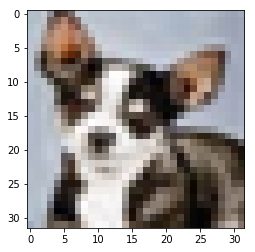

im_shape的维度： (1, 3, 32, 32)
Predict begin...
step 1/1 [==============================] - 10ms/step
Predict samples: 1
infer results: airplane


In [18]:
#定义标签列表
label_list = [ "airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse","ship", "truck"]
#读入测试图片并展示
infer_path='/home/aistudio/data/data7940/dog.png'
img = Image.open(infer_path)
plt.imshow(img)   
plt.show()    

#载入要预测的图片
infer_img = load_image(infer_path)
infer_img = infer_img.reshape(1,1,3,32,32)
#将图片变为数组
# infer_img=np.array(infer_img).astype('float32')
#进行预测
result = model.predict(infer_img)
# 输出预测结果
# print('results',result)
print("infer results: %s" % label_list[np.argmax(result[0][0])])  